In [1]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from matplotlib import pyplot
import pyreadstat as prs
import numpy as np
from tensorflow.keras.models import Model, load_model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [8]:
# long_df, long_meta = prs.read_sav('../data/uktus15_diary_ep_long.sav', encoding="latin1")

In [32]:
long_df = pd.read_csv('../data/Iris.csv')
long_df['Species'] = long_df['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
y = np.array(long_df['Species'])
print(y)
y = tf.keras.utils.to_categorical(y, dtype ="uint8")
long_df = long_df[['SepalLengthCm',  'SepalWidthCm',  'PetalLengthCm',  'PetalWidthCm',  'Species']]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [34]:
y[50:100]

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint8)

In [29]:
long_df['Species'].value_counts()

0    100
1     50
Name: Species, dtype: int64

In [31]:
long_df.dtypes

SepalLengthCm    float64
SepalWidthCm     float64
PetalLengthCm    float64
PetalWidthCm     float64
Species            uint8
dtype: object

In [35]:

# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(BatchNormalization())
	model.add(Dense(50, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.2))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model


In [36]:

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(BatchNormalization())
	model.add(Dense(50, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.2))
	model.add(Dense(n_outputs, activation='linear'))
	return model


In [37]:

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model


In [38]:

# generate n real samples with class labels
def generate_real_samples(n):
	# # generate inputs in [-0.5, 0.5]
	# X1 = rand(n) - 0.5
	# # generate outputs X^2
	# X2 = X1 * X1
	# # stack arrays
	# X1 = X1.reshape(n, 1)
	# X2 = X2.reshape(n, 1)
	# X = hstack((X1, X2))
	# # generate class labels
	y = ones((n, 1))
	# long_df, long_meta = prs.read_sav('../data/uktus15_diary_ep_long.sav', encoding="latin1")
	# long_df = long_df.iloc[:1000]
	long_df = pd.read_csv('../data/Iris.csv')
	long_df['Species'] = long_df['Species'].map({'Iris-setosa':1, 'Iris-versicolor': 2, 'Iris-virginica': 3})
	long_df = long_df[['SepalLengthCm',  'SepalWidthCm',  'PetalLengthCm',  'PetalWidthCm',  'Species']]
	idx = np.random.randint(0, long_df.shape[0], n)
	X = long_df.iloc[idx]
	return X, y


In [39]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input


In [40]:

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y


In [41]:

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	# pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	# pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	# pyplot.show()


In [42]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=1000, n_batch=128, n_eval=100):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)
	return gan_model


In [43]:

# size of the latent space
latent_dim = 10
ncols = long_df.shape[1]
# create the discriminator
discriminator = define_discriminator(ncols)
# create the generator
generator = define_generator(latent_dim, ncols)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
gan_model = train(generator, discriminator, gan_model, latent_dim)

In [18]:
gan_model.save('../models/gan_modelv1.h5')

In [19]:
gan_model = load_model('../models/gan_modelv1.h5')

In [44]:
X, _ = generate_fake_samples(generator, 10, 100)

In [45]:
df = pd.DataFrame(X, columns = long_df.columns)

In [46]:
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,0.294620,-0.500982,-0.368352,-0.333081,-1.664628
1,-0.527261,0.653200,-0.325841,0.757018,-1.948311
2,0.781885,0.222929,-1.889272,-0.854669,-2.794788
3,-1.498284,-0.045351,0.706387,0.057637,-1.517749
4,-0.442760,-0.694076,-0.430386,0.073973,-1.520483


In [72]:
long_df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [73]:
long_df.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,2.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,1.000000
25%,5.100000,2.800000,1.600000,0.300000,1.000000
50%,5.800000,3.000000,4.350000,1.300000,2.000000
75%,6.400000,3.300000,5.100000,1.800000,3.000000
max,7.900000,4.400000,6.900000,2.500000,3.000000


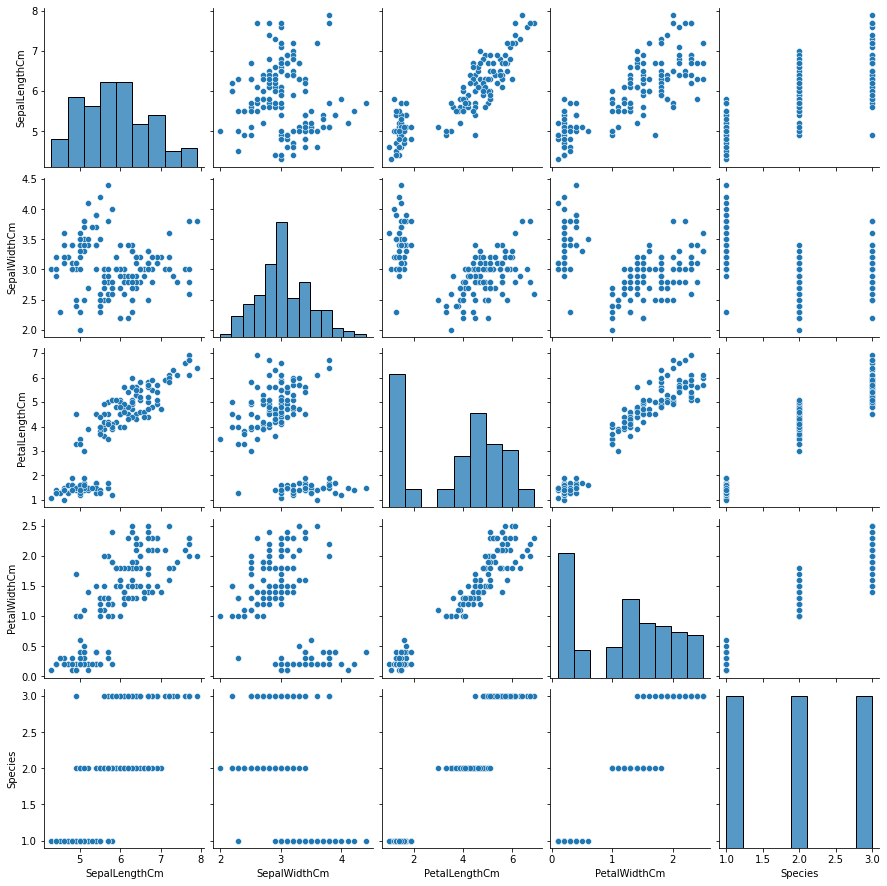

In [78]:
sns.pairplot(long_df)

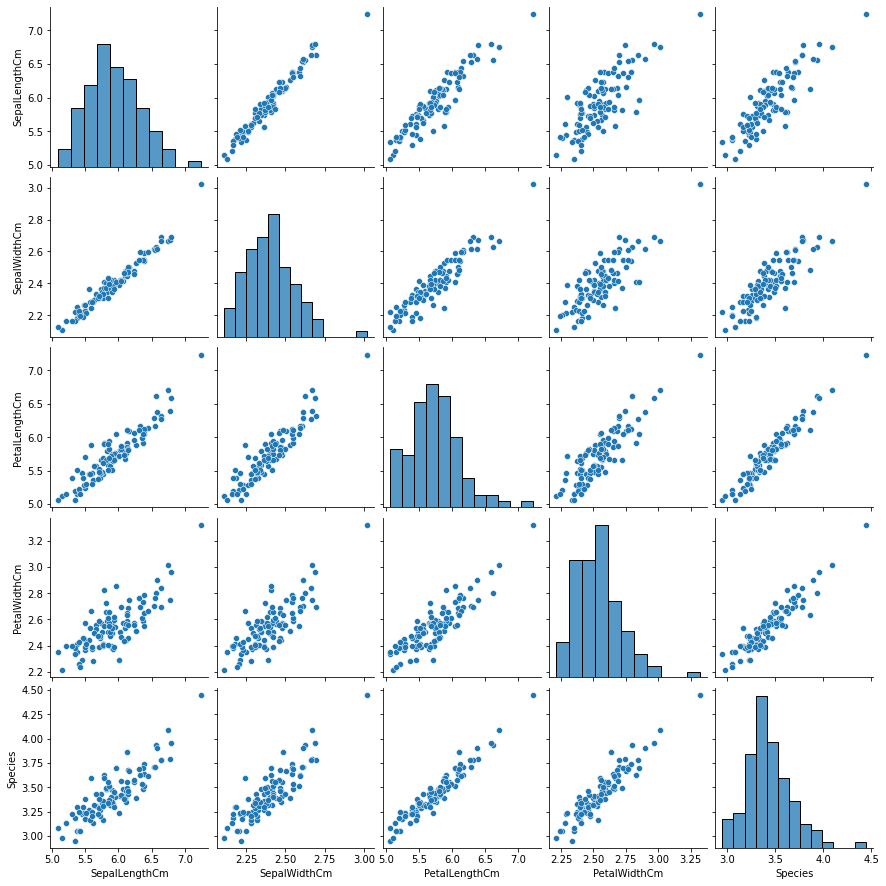

In [79]:
sns.pairplot(df)

In [75]:
df.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,5.925742,2.399696,5.737557,2.548529,3.434607
std,0.403679,0.150135,0.383458,0.177431,0.244006
min,5.086774,2.109150,5.060616,2.212409,2.951273
25%,5.650138,2.306153,5.471430,2.412175,3.282737
50%,5.883714,2.392568,5.709032,2.538096,3.397841
75%,6.144402,2.475950,5.923447,2.650546,3.559465
max,7.242650,3.021667,7.234111,3.319960,4.445230


In [76]:
df = pd.DataFrame(X, columns = long_df.columns)
